# Laboratorio 1: Comparación de algoritmos de Series de Tiempo

## 1. Importar librerías

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
sns.set_style('whitegrid')

## 2. Funciones auxiliares

In [14]:
def plot_series(series, title=None):
    plt.figure(figsize=(12, 5))
    plt.plot(series)
    if title:
        plt.title(title)
    plt.show()

def evaluate_forecast(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae  = mean_absolute_error(actual, predicted)
    return {'RMSE': rmse, 'MAE': mae}

# 3.Funcion reutilizable para sarima


In [15]:
def sarima_grid(series, seasonal_periods, max_p=2, max_d=1, max_q=2,
                max_P=1, max_D=1, max_Q=1):
    """
    Busca la mejor combinación (p,d,q)(P,D,Q,s) según AIC.
    Devuelve el modelo ajustado y el orden/seasonal_order elegidos.
    """
    best_aic = np.inf
    best_order = None
    best_seasonal = None
    best_model   = None

    from itertools import product
    ps = range(max_p+1); ds = range(max_d+1); qs = range(max_q+1)
    Ps = range(max_P+1); Ds = range(max_D+1); Qs = range(max_Q+1)

    for (p,d,q), (P,D,Q) in product(product(ps,ds,qs), product(Ps,Ds,Qs)):
        try:
            mdl = SARIMAX(series,
                          order=(p,d,q),
                          seasonal_order=(P,D,Q,seasonal_periods),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            res = mdl.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,d,q)
                best_seasonal = (P,D,Q,seasonal_periods)
                best_model = res
        except Exception:
            continue
    print(f"Mejor SARIMA: {best_order} x {best_seasonal} | AIC = {best_aic:.2f}")
    return best_model, best_order, best_seasonal


# 4. Pipeline para el DF

In [16]:
def pipeline(df, y_col, date_col, seasonal_periods, test_len=30,
             freq='D'):
    """
    df           : DataFrame con índice temporal
    y_col        : nombre de la columna a predecir
    date_col     : nombre de la columna de fecha (para Prophet)
    seasonal_periods: 7 días o 12 meses
    test_len     : longitud del hold-out
    freq         : 'D' para día, 'M' para mes
    """
    plot_series(df[y_col], f'{y_col} (original)')
    # Descomposición
    decomp = seasonal_decompose(df[y_col], model='additive', period=seasonal_periods)
    decomp.plot(); plt.show()

    # Promedios móviles
    for w in [seasonal_periods, seasonal_periods*2, seasonal_periods*3]:
        df[f'MA_{w}'] = df[y_col].rolling(window=w).mean()
    plot_series(df[[y_col]+[c for c in df.columns if 'MA_' in c]].dropna(),
                f'{y_col} vs Promedios Móviles')

    # Simple Exponential Smoothing
    ses = SimpleExpSmoothing(df[y_col]).fit()
    df['SES'] = ses.fittedvalues
    plot_series(df[[y_col,'SES']], 'SES')

    # Holt-Winters
    hw = ExponentialSmoothing(df[y_col],
                              trend='add',
                              seasonal='add',
                              seasonal_periods=seasonal_periods).fit()
    df['HW'] = hw.fittedvalues
    plot_series(df[[y_col,'HW']], 'Holt-Winters')

    # SARIMA
    sarima_model, order, seasonal = sarima_grid(df[y_col], seasonal_periods)
    df['SARIMA'] = sarima_model.fittedvalues
    plot_series(df[[y_col,'SARIMA']], 'SARIMA')

    # Prophet
    prop_df = df.reset_index().rename(columns={date_col:'ds', y_col:'y'})
    m = Prophet()
    m.fit(prop_df)
    future = m.make_future_dataframe(periods=test_len, freq=freq)
    fcst = m.predict(future)
    m.plot(fcst); plt.show()

    # Train/Test split
    train = df.iloc[:-test_len]
    test  = df.iloc[-test_len:]

    # Predicciones
    results = {}
    # SES
    pred_ses = ses.forecast(test_len)
    results['SES'] = evaluate_forecast(test[y_col], pred_ses)

    # HW
    pred_hw = hw.forecast(test_len)
    results['Holt-Winters'] = evaluate_forecast(test[y_col], pred_hw)

    # SARIMA
    pred_sarima = sarima_model.get_forecast(steps=test_len).predicted_mean
    results['SARIMA'] = evaluate_forecast(test[y_col], pred_sarima)

    # Prophet
    pred_prop = fcst.set_index('ds').loc[test.index, 'yhat']
    results['Prophet'] = evaluate_forecast(test[y_col], pred_prop)

    print(pd.DataFrame(results).T)
    return df, results

# ==========================================
# 4.  LECTURA Y EJECUCIÓN
# ==========================================


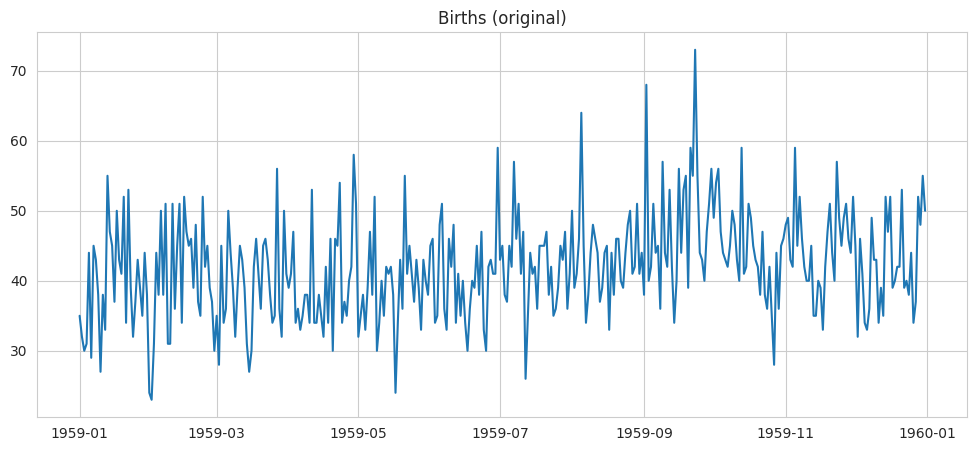

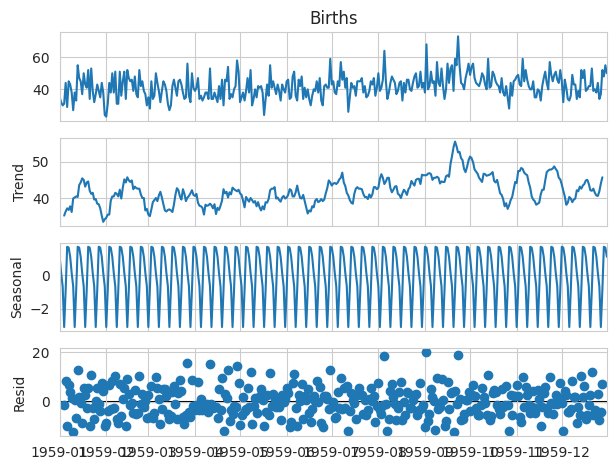

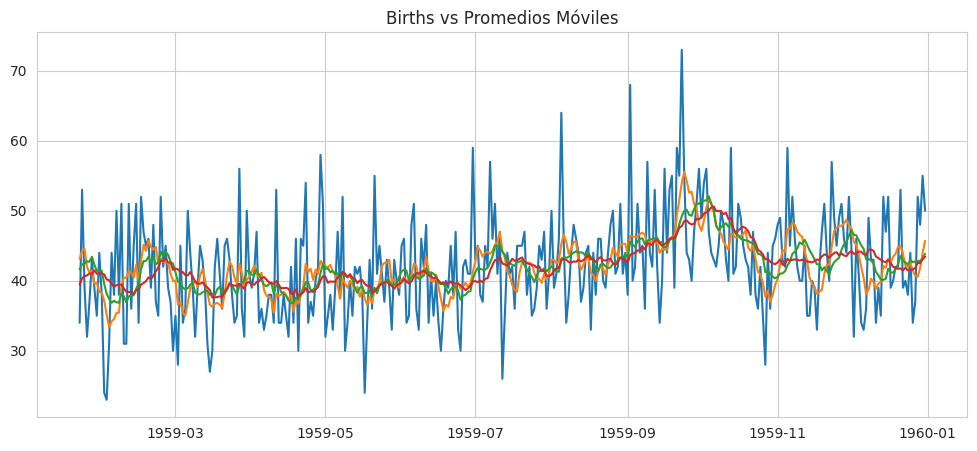

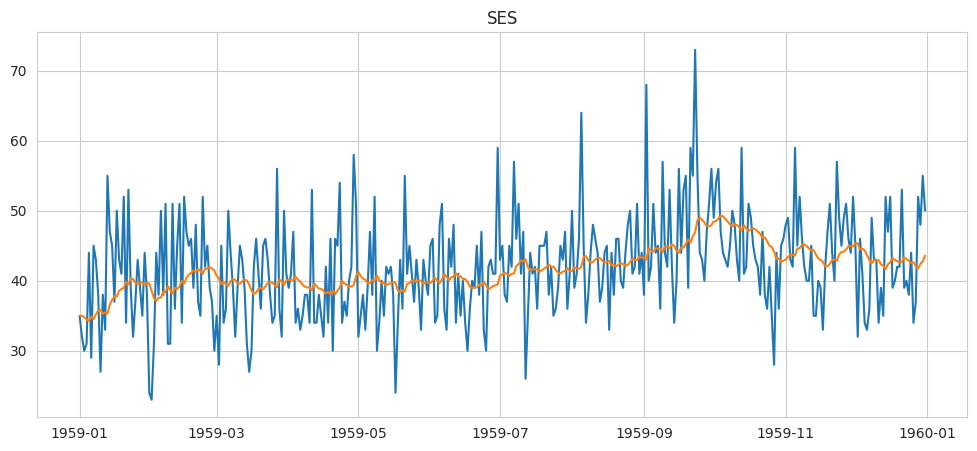

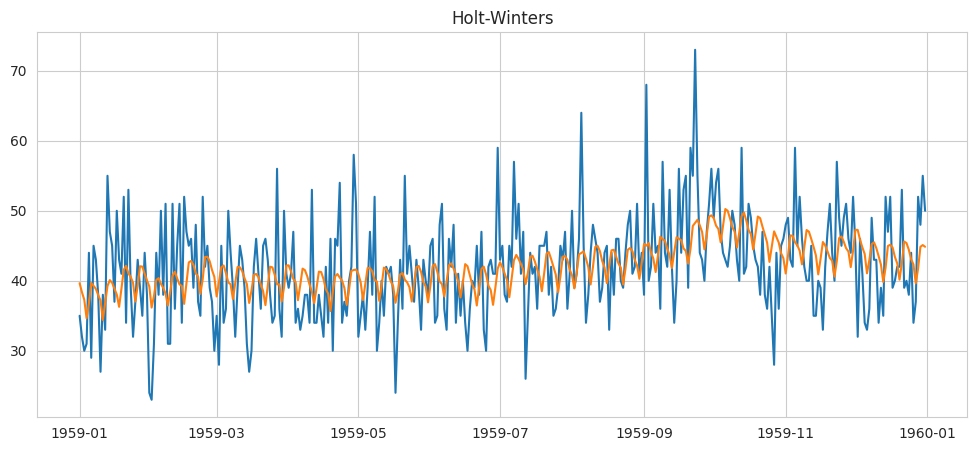

Mejor SARIMA: (1, 0, 2) x (0, 1, 1, 7) | AIC = 2350.34


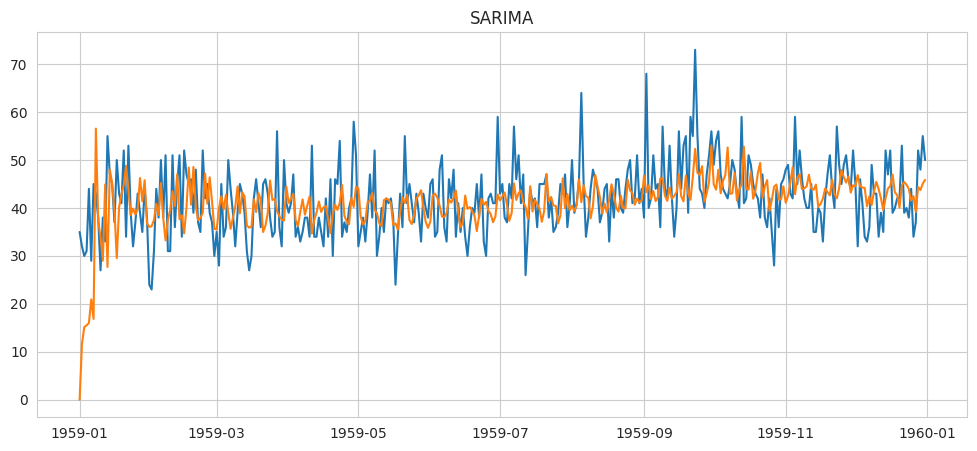

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5nm43ews/6d2dr5y3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5nm43ews/_3exk4yv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49015', 'data', 'file=/tmp/tmp5nm43ews/6d2dr5y3.json', 'init=/tmp/tmp5nm43ews/_3exk4yv.json', 'output', 'file=/tmp/tmp5nm43ews/prophet_modelkq6ikzwl/prophet_model-20250721025150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:51:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:51:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


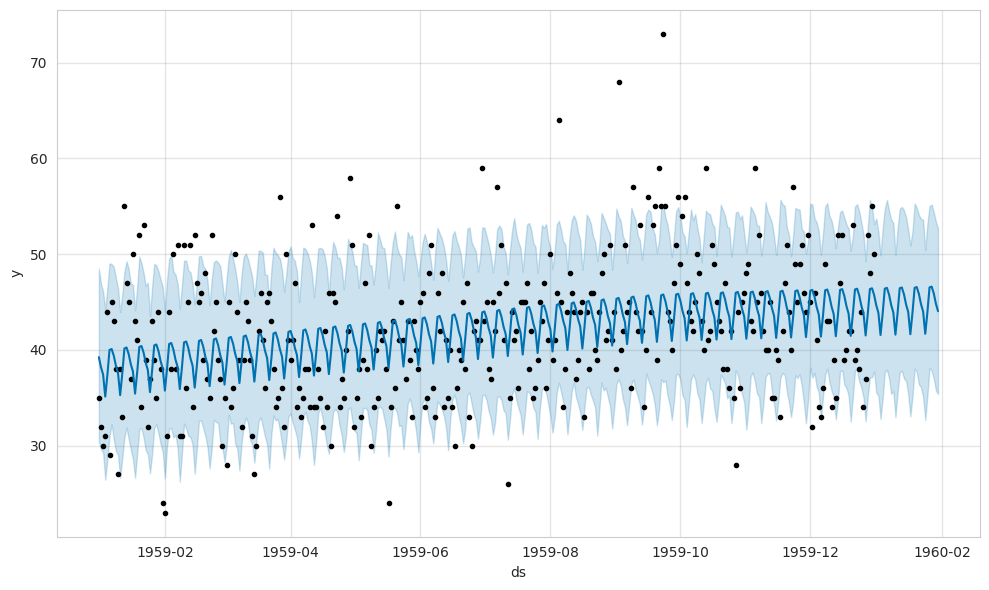

                  RMSE       MAE
SES           6.846316  5.970450
Holt-Winters  6.711562  5.683770
SARIMA        7.139897  6.000185
Prophet       6.655988  5.698079


In [21]:
# DataFrame 1 – daily births
df1 = pd.read_csv('daily-total-female-births.csv', parse_dates=['Date'], index_col='Date')
df1, res1 = pipeline(df1, y_col='Births', date_col='Date',
                     seasonal_periods=7, test_len=30, freq='D')

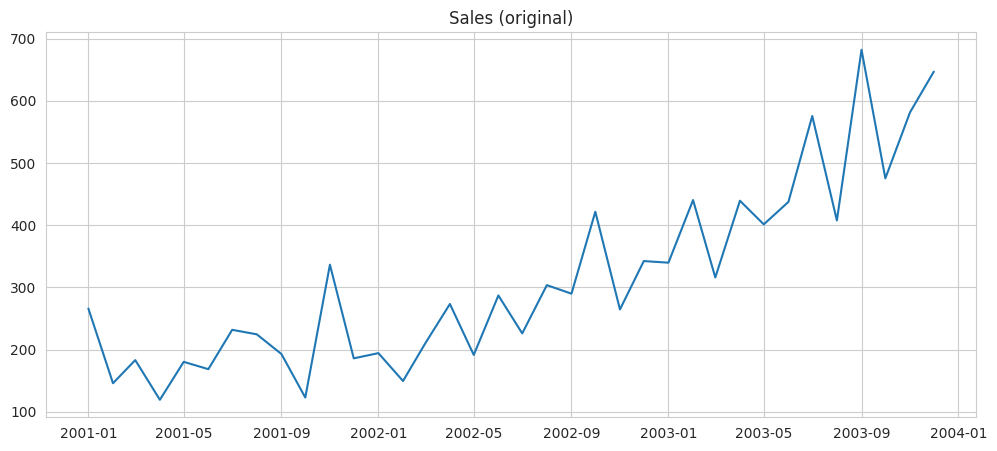

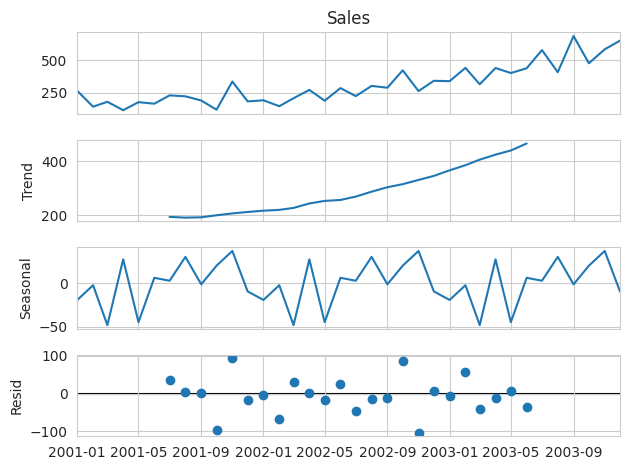

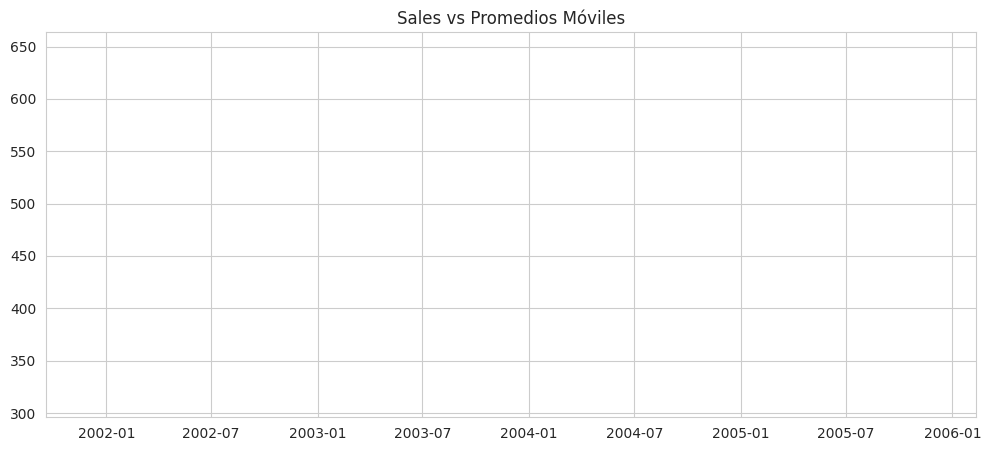

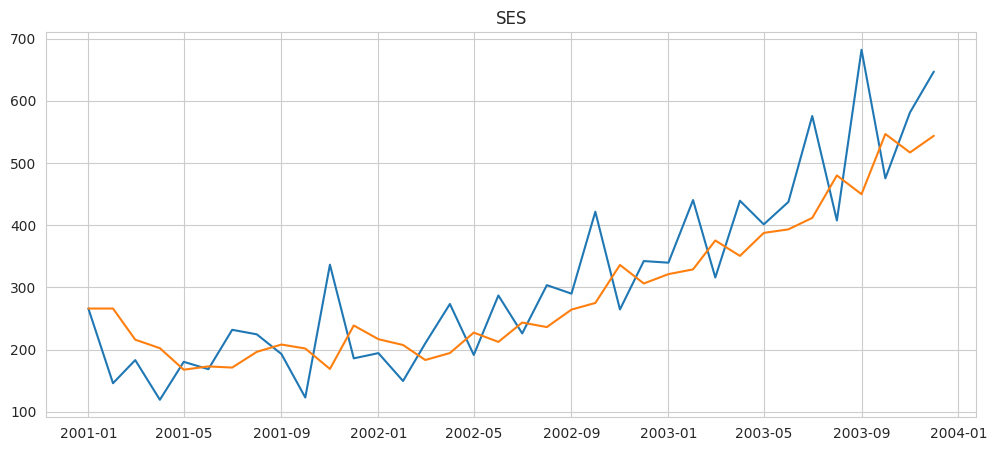

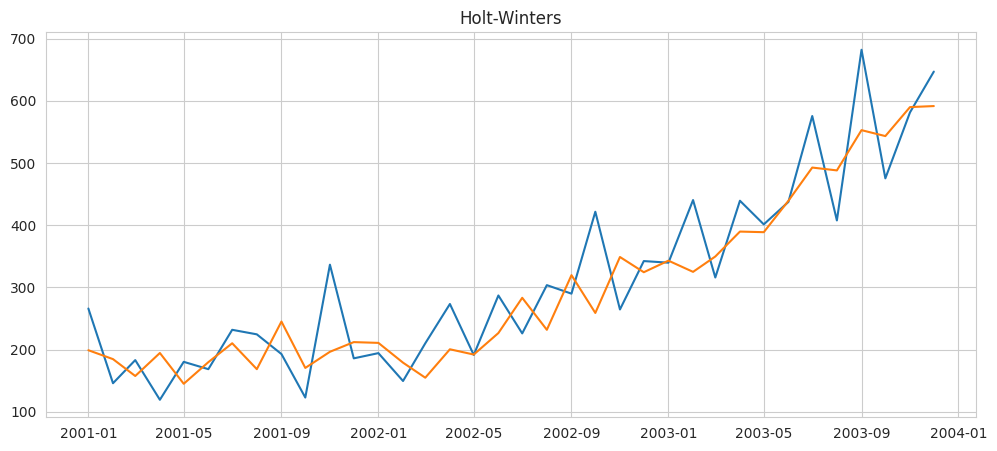

Mejor SARIMA: (2, 1, 2) x (0, 1, 1, 12) | AIC = 87.01


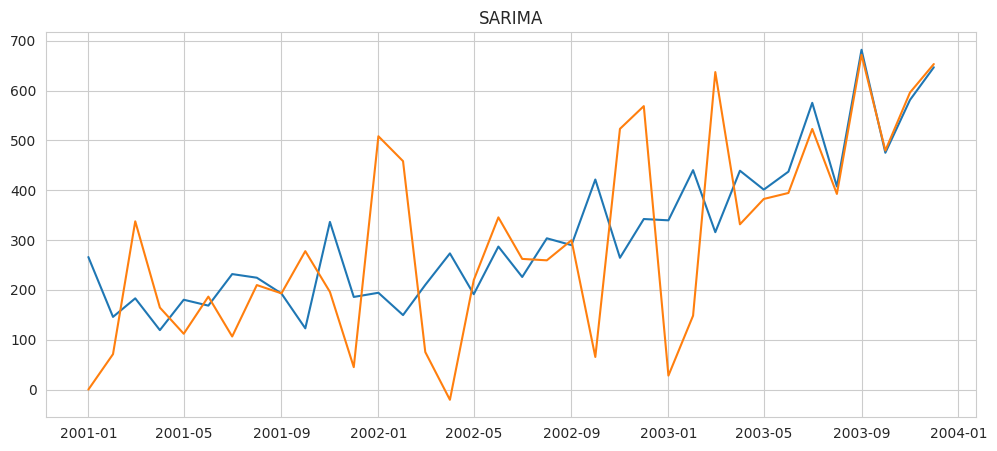

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5nm43ews/u7rmkw4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5nm43ews/ycx63ez0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62162', 'data', 'file=/tmp/tmp5nm43ews/u7rmkw4k.json', 'init=/tmp/tmp5nm43ews/ycx63ez0.json', 'output', 'file=/tmp/tmp5nm43ews/prophet_modelke7rx9ea/prophet_model-20250721025546.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


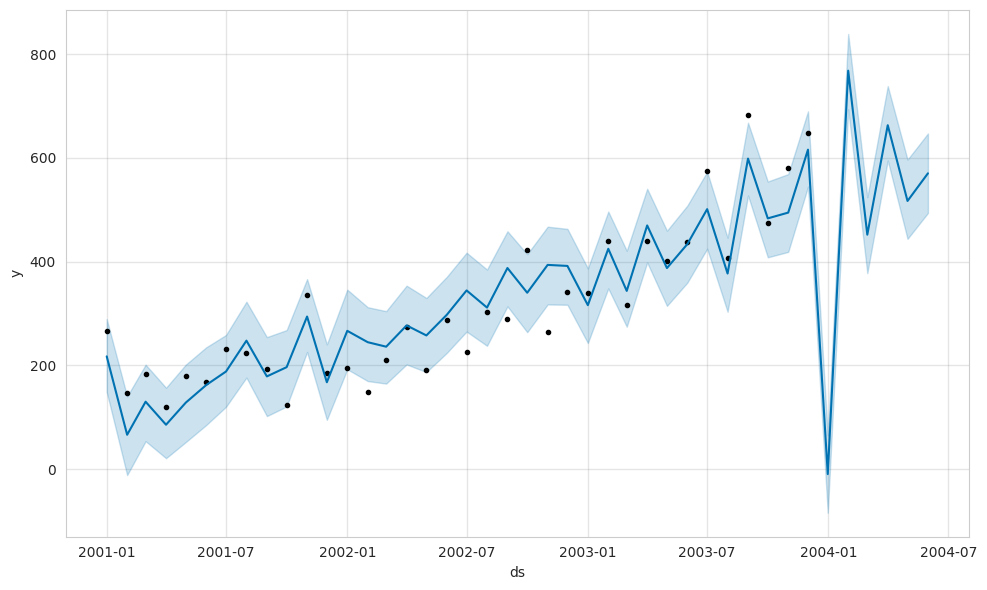

                    RMSE         MAE
SES            97.774487   77.112746
Holt-Winters  137.645948  119.406167
SARIMA        556.530090  489.536560
Prophet        60.612828   52.436706


In [23]:
# 1) Leer sin parsear fechas
df2_raw = pd.read_csv('shampoo.csv')

# 2) Crear rango mensual comenzando en enero-2001
df2_raw['Month'] = pd.date_range(start='2001-01', periods=len(df2_raw), freq='MS')

# 3) Fijar índice y columna de ventas
df2 = df2_raw.set_index('Month')

# 4) Continuar con tu pipeline
df2, res2 = pipeline(df2, y_col='Sales', date_col='Month',
                     seasonal_periods=12, test_len=6, freq='M')

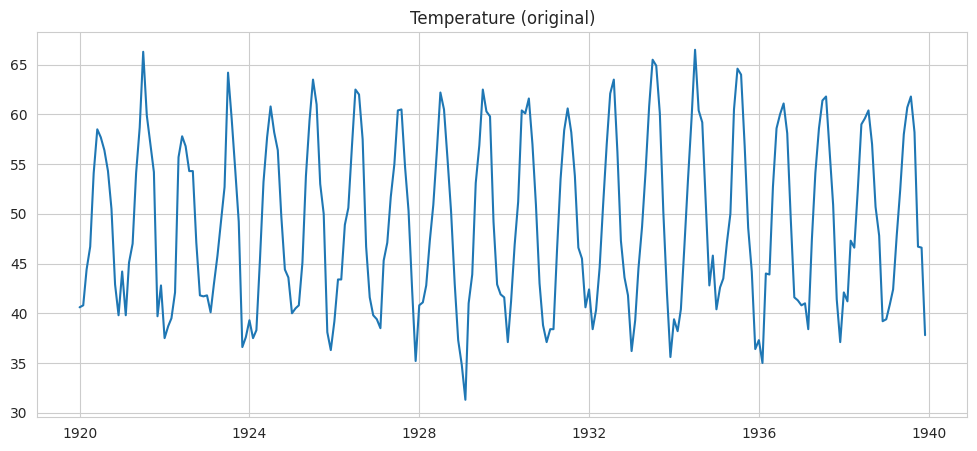

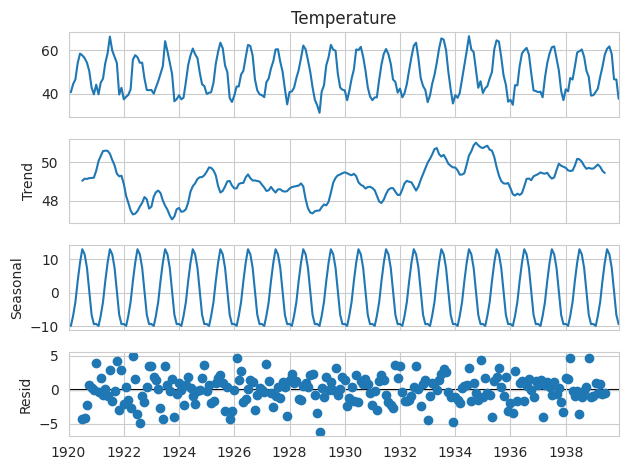

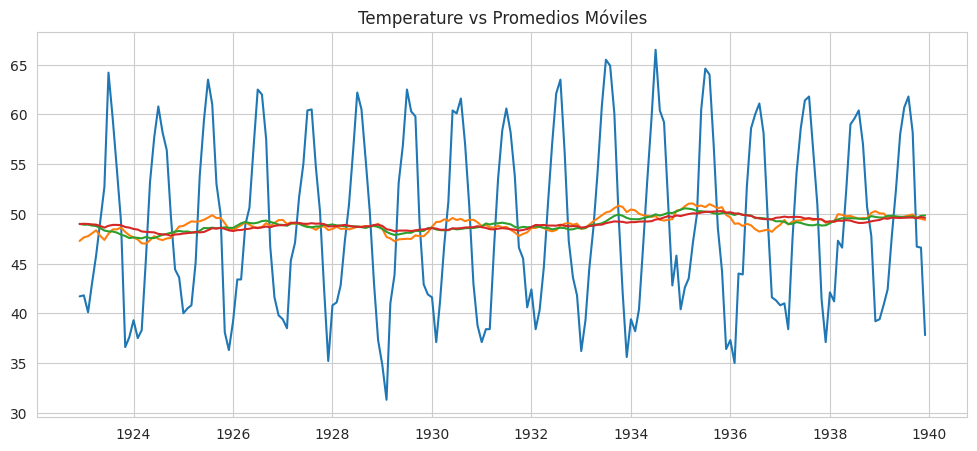

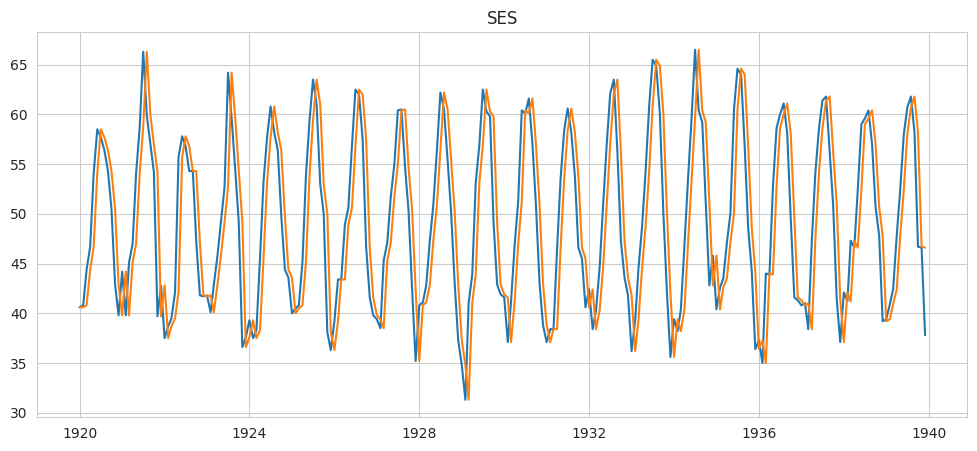

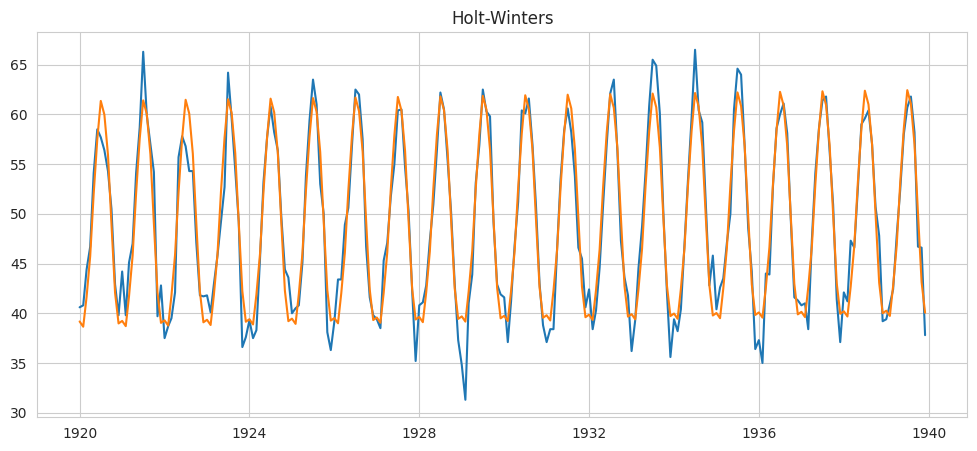

In [ ]:
# DataFrame 3 – monthly mean temperature
df3 = pd.read_csv('monthly-mean-temp.csv', parse_dates=['Month'], index_col='Month')
df3, res3 = pipeline(df3, y_col='Temperature', date_col='Month',
                     seasonal_periods=12, test_len=12, freq='M')

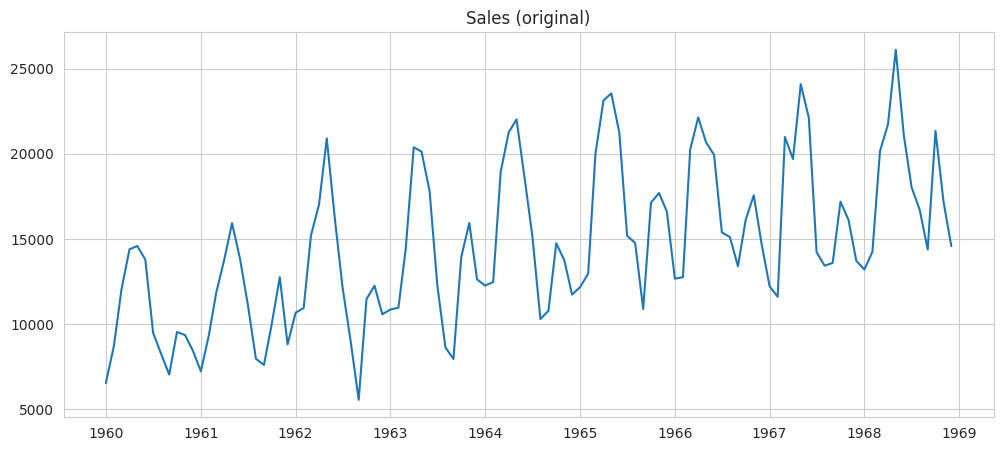

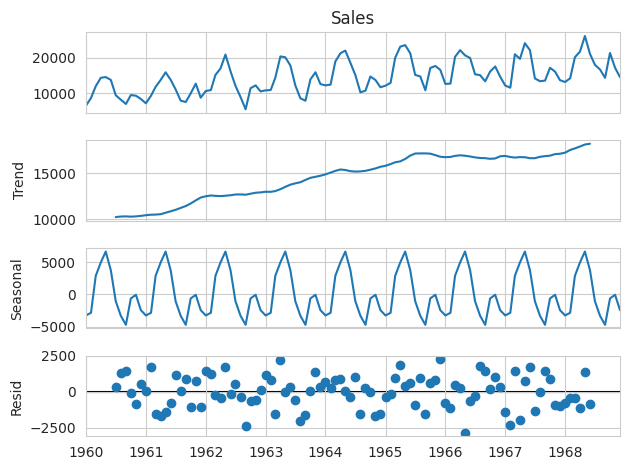

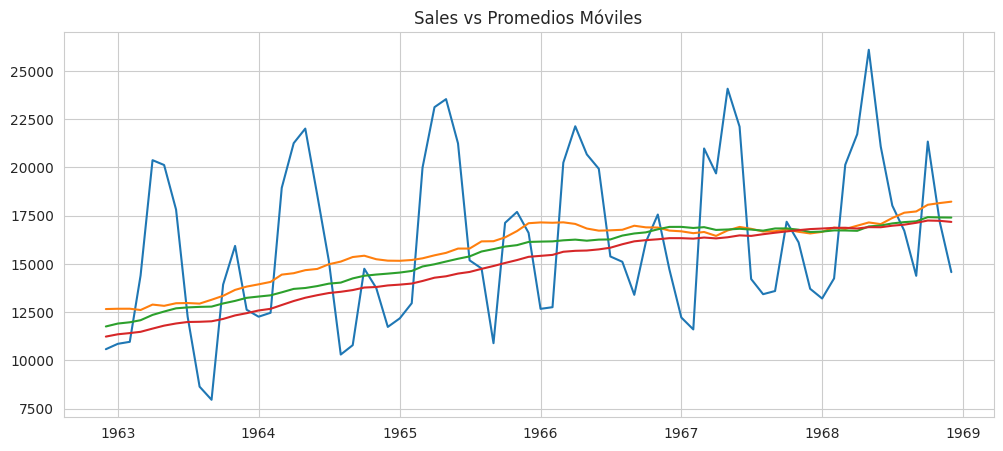

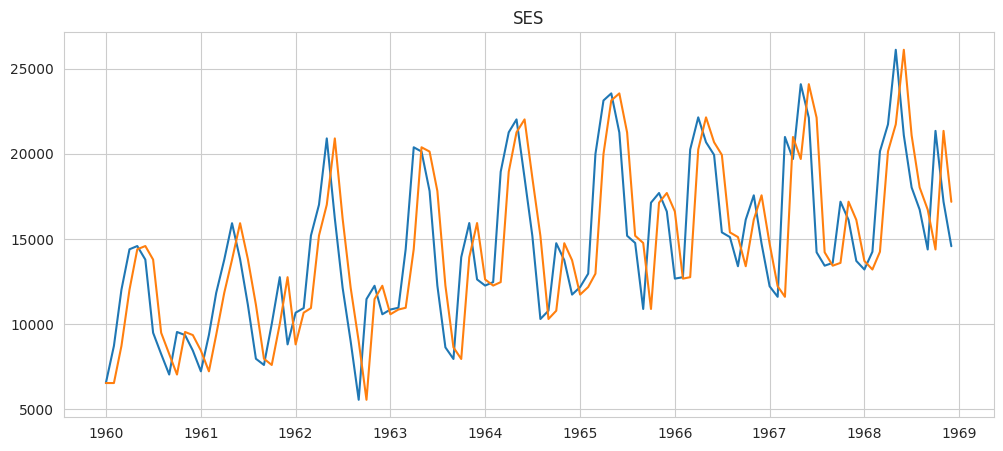

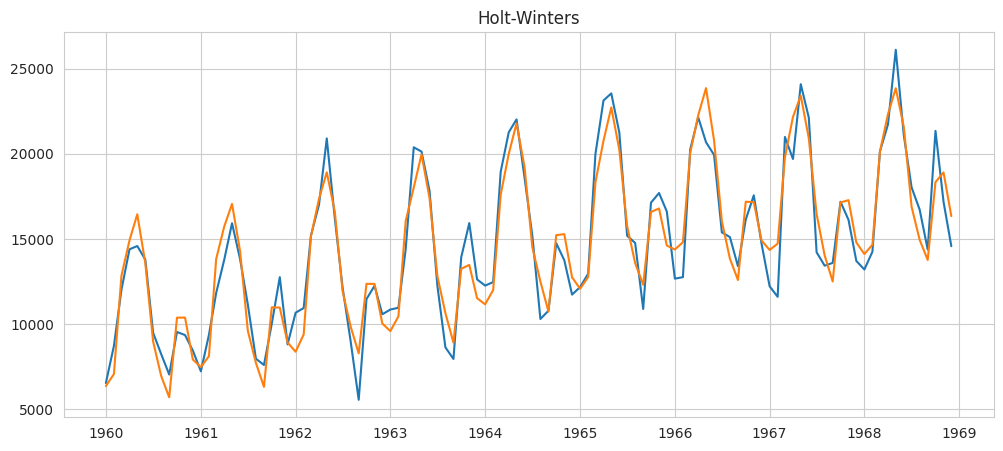

Mejor SARIMA: (0, 1, 2) x (0, 1, 1, 12) | AIC = 1420.18


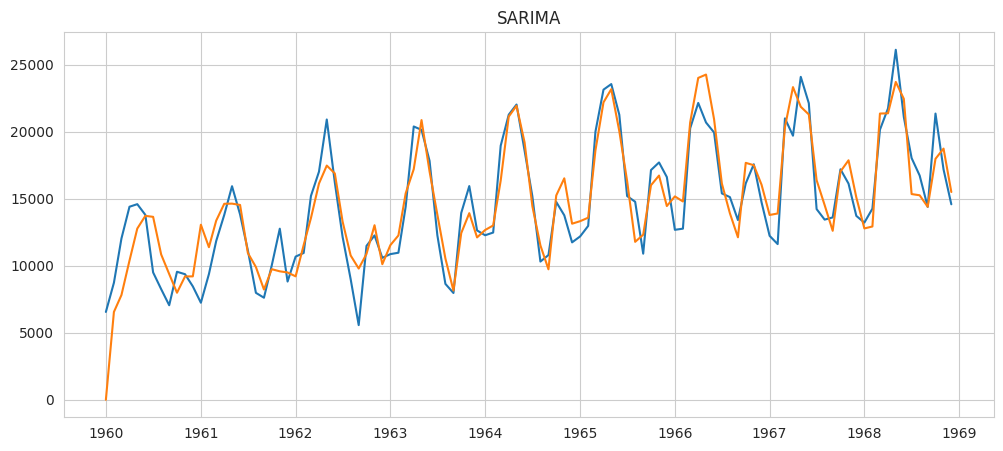

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5nm43ews/svmtomzt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5nm43ews/jgu3tet_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88317', 'data', 'file=/tmp/tmp5nm43ews/svmtomzt.json', 'init=/tmp/tmp5nm43ews/jgu3tet_.json', 'output', 'file=/tmp/tmp5nm43ews/prophet_modeljk5b05ah/prophet_model-20250721025921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:59:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:59:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


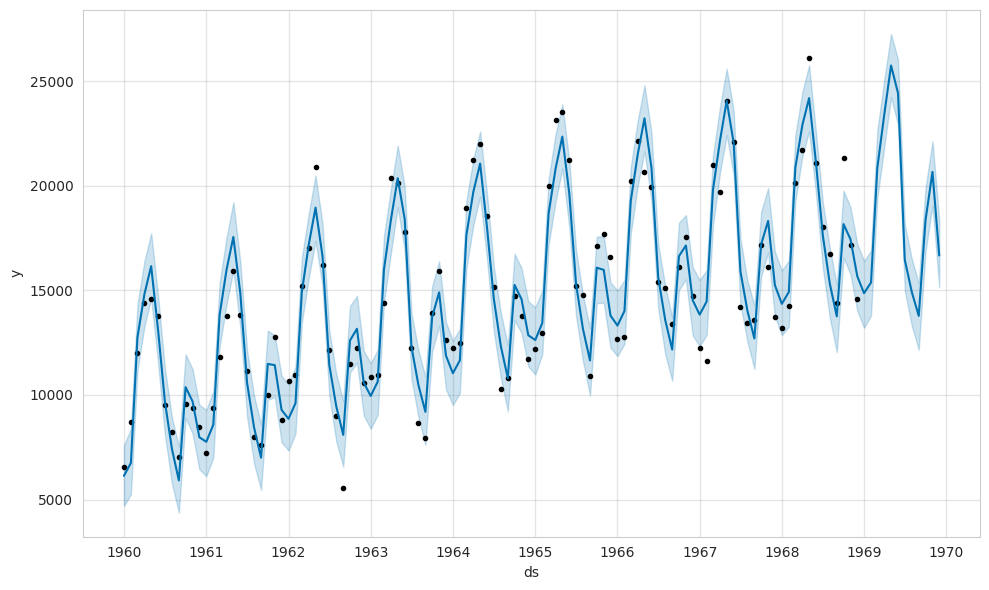

                     RMSE          MAE
SES           5229.426152  3965.333320
Holt-Winters  1755.201136  1552.488377
SARIMA         971.759137   816.881585
Prophet       1327.627152  1050.900963


In [25]:
# DataFrame 4 – monthly car sales
df4 = pd.read_csv('monthly-car-sales.csv', parse_dates=['Month'], index_col='Month')
df4, res4 = pipeline(df4, y_col='Sales', date_col='Month',
                     seasonal_periods=12, test_len=12, freq='M')